In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import staintools

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *

In [5]:
from fastai.callbacks.hooks import  params_size
def extract_train_information(learner: Learner):
    _, params, trainables, _ = params_size(learner.model)

    total_params = sum(params)
    trainable_ratio = sum([param*train for param, train in zip(params, trainables)]) / total_params * 100

    bs = learner.data.batch_size
    image_size = learner.data.valid_ds[0][0].size
    wd = learner.wd
    lr = max(learner.recorder.lrs)

    summary = "\nTotal params: {:,}".format(total_params)
    summary += f"\nTrainable: {round(trainable_ratio,2)}%"
    summary += f"\nBs: {bs}"
    summary += f"\nwd: {wd}"
    summary += f"\nlr: {lr}"
    summary += f"\nImage: {image_size}\n"

    for tf in learner.data.train_dl.dl.dataset.tfms:
        summary += f"\n {tf}"
    
    return summary

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/norm/')

In [7]:
np.random.seed(42)

In [8]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/norm/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/norm/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/norm/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/norm/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/norm/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [9]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [10]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

## Split data into train val 

In [11]:
split_handler = SplitByPatient(hem_patients, all_patints)

### Split by regex

In [12]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

In [13]:
print('Train Total: {0}'.format(len(hem_train)+len(all_train)))
print('Val Total: {0}'.format(len(hem_val)+len(all_val)))
print("")
print('Hem train: {}'.format(len(hem_train)))
print('All train: {}'.format(len(all_train)))
print('Hem val: {}'.format(len(hem_val)))
print('All val: {}'.format(len(all_val)))

Train Total: 7108
Val Total: 3517

Hem train: 2293
All train: 4815
Hem val: 1060
All val: 2457


In [14]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

### Stain normalization

/data/Datasets/WhiteBloodCancer/norm/fold_0/hem/UID_H7_2_1_hem.bmp


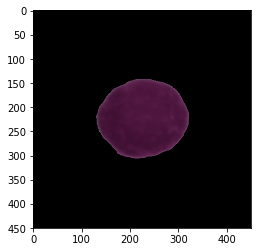

In [15]:
file_name = hem_train[0]
print(file_name)
ref_image = np.asarray(PIL.Image.open(file_name).convert('RGB'))
ref_image.setflags(write=1)

plt.imshow(ref_image)

### Use just the cell

In [16]:
class ImageItemListCell(ImageItemList):

    def open(self, fn):
        #image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)
        image = np.asarray(PIL.Image.open(fn).convert(self.convert_mode))
        
        rows = np.any(image, axis=1)
        cols = np.any(image, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        sub_image = image[rmin:rmax, cmin:cmax] / 255.

        return Image(pil2tensor(sub_image, np.float32))
    
valid = ImageItemListCell(hem_val+all_val)
train = ImageItemListCell(hem_train+all_train)

In [17]:
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

#### Data augmentation

In [18]:
def _cutout(img, n_holes:int = 5, length:float = 0.05)->Tensor:
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (float): The length (in percent of the image size) of each square patch.
    """
    h = img.size(1)
    w = img.size(2)
    patch_width = int(w * length)
    path_height = int(h * length)

    mask = np.ones((h, w), np.float32)

    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - path_height // 2, 0, h)
        y2 = np.clip(y + path_height // 2, 0, h)
        x1 = np.clip(x - patch_width // 2, 0, w)
        x2 = np.clip(x + patch_width // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    return img * mask
cutout = TfmLighting(_cutout)

In [19]:
xtra_tfms=[squish(scale=0.66), cutout(n_holes=5, length=0.2)]
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0.15, 
                      max_zoom=1.5, 
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

#### Create dataset 

In [20]:
def get_data(bs, size):
    data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, 
                                      ds_tfms=tfms, padding_mode='zeros',
                                      resize_method=ResizeMethod.PAD)
    data = data.normalize()
    #data = data.normalize((channel_mean, channel_std))
    return data
    

### Start training 256

In [21]:
experiment_name = 'rn34'

In [22]:
size = 450
bs = 128 

In [23]:
gc.collect();

In [24]:
learn = create_cnn(get_data(bs, size), models.resnet34, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.4, gamma=0.5),
                   #ps=0.75,
                   wd=0.001,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  ).to_fp16().mixup()                

In [25]:
learn.callback_fns

[fastai.basic_train.Recorder,
 fastai.train.ShowGraph,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, monitor='mcc', mode='max', name='stage1-rn34-450'),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [26]:
#learn.lr_find()
#learn.recorder.plot()

In [27]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.744491,0.649284,0.355701,0.655430,0.228629
2,0.621984,0.630009,0.330111,0.680638,0.290436
3,0.578928,0.667335,0.294854,0.590652,0.119713
4,0.551936,0.671960,0.367643,0.647144,0.255856
5,0.516467,0.702802,0.293432,0.592868,0.136389
6,0.498609,0.526926,0.266136,0.737662,0.388920
7,0.479947,0.479519,0.209554,0.770941,0.462546
8,0.467562,0.548545,0.223770,0.728134,0.436090
9,0.461718,0.495914,0.225192,0.760365,0.425041
10,0.458703,0.489625,0.206142,0.773434,0.472090


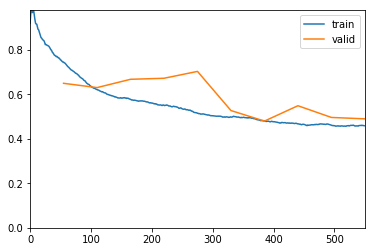


Total params: 21,813,570
Trainable: 2.5%
Bs: 128
wd: 0.001
lr: 0.01
Image: torch.Size([450, 450])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.4286956928533523, 'col_pct': 0.14906849480808082, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 4}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.0725, -0.1266,  0.0196, -0.1816]), 'invert': False}, do_run=False, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': 20.86427028634732}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=0.75, resolved={'row_pct': 0.4851575826157912, 'col_pct': 0.6105607353787145, 'scale': 1.4793541536

In [28]:
learn.fit_one_cycle(10, lr) #, pct_start=0.8
print(extract_train_information(learn))

##### And fine-tune the whole model

In [29]:
learn.unfreeze()

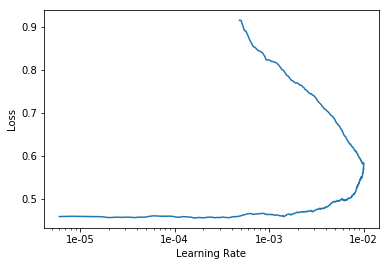

In [30]:
#learn.lr_find()
learn.recorder.plot()

In [31]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.443871,0.494961,0.200739,0.777936,0.488022
2,0.447369,0.556140,0.268979,0.731164,0.361948
3,0.450966,0.502355,0.210691,0.766993,0.458521
4,0.448723,0.666797,0.341200,0.672126,0.301414
5,0.445572,0.484424,0.195906,0.785860,0.501849
6,0.440749,0.496798,0.207848,0.774602,0.468301
7,0.432962,0.495034,0.200171,0.772847,0.493212
8,0.428987,0.468021,0.195906,0.786773,0.501903
9,0.429739,0.472406,0.191356,0.787019,0.516688
10,0.423469,0.479144,0.192778,0.784606,0.513034


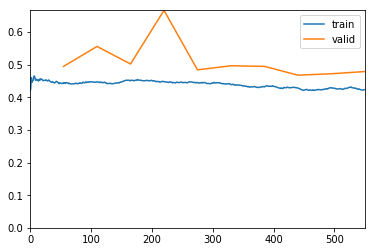


Total params: 21,813,570
Trainable: 100.0%
Bs: 128
wd: 0.001
lr: 0.0020000000000000005
Image: torch.Size([450, 450])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.4286956928533523, 'col_pct': 0.14906849480808082, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 4}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.0725, -0.1266,  0.0196, -0.1816]), 'invert': False}, do_run=False, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': 20.86427028634732}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=0.75, resolved={'row_pct': 0.4851575826157912, 'col_pct': 0.6105607353787145, 's

In [32]:
learn.fit_one_cycle(10, slice(1e-5,lr/5))
print(extract_train_information(learn))